有些人认为SVM是最好的现成的分类器，这里的“现成”是指分类器不加修改即可直接使用，同时也意味着在数据上应用基本形式的SVM分类器就可以得到地错误率的结果。

## 1. 基于最大间隔分隔数据

> 优点：泛化错误率低，计算开销不大，结果易理解

> 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适用于处理二类数据

> 适用数据类型：数值型和标称型数据

将数据姐分隔开来的直线称为分割超平面（separating hyperplane），支持向量（support vector）就是离分隔超平面最近的那些店，接下来就是要试着最大化支持向量到分隔面的距离，需要找到此问题的优化求解方法。

## 2. 寻找 最大间隔

### 2.1 分类器求解的优化问题

公式推导比较复杂，涉及到拉格朗日乘子，而且还有引入松弛变量等方法，建议查看相关教材：Pattern Recognition and Machine Learning

### 2.2 SVM应用的一般框架

> 收集数据
    
> 准备数据：需要数值型数据

> 分析数据：有助于可视化分割超平面

> 训练算法：SVM的大部分时间都源自寻来你，该过程主要实现两个参数的调优

> 测试算法

> 使用算法：几乎所有的分类问题都可以使用SVM，但SVM本身是个二类分类器，多类问题需要修改

## 3. SMO高效优化算法（简化版）

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def loadDataSet(fileName):
    dataMat = []
    labelMat = []
    with open(fileName) as f:
        for line in f.readlines():
            lineArr = line.strip().split('\t')
            dataMat.append([float(lineArr[0]), float(lineArr[1])])
            labelMat.append(float(lineArr[-1]))
    return dataMat, labelMat

In [3]:
def selectJrand(i, m):
    j = i
    while (j == i):
        j = int(np.random.uniform(0, m))
    return j

In [4]:
# 调整大于H或者小于L的alpha
def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

In [5]:
dataArr, labelArr = loadDataSet('testSet.txt')
dataArr[:10], labelArr[:10]

([[3.542485, 1.977398],
  [3.018896, 2.556416],
  [7.55151, -1.58003],
  [2.114999, -0.004466],
  [8.127113, 1.274372],
  [7.108772, -0.986906],
  [8.610639, 2.046708],
  [2.326297, 0.265213],
  [3.634009, 1.730537],
  [0.341367, -0.894998]],
 [-1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0])

In [14]:
# 简化版SMO算法
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn)
    labelMat = np.mat(classLabels).transpose()
    b = 0
    m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
                    print("L==H")
                    continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0: 
                    print ("eta>=0")
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): 
                    print ("j not moving enough")
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): 
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): 
                    b = b2
                else: 
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                print("iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
        if (alphaPairsChanged == 0): 
            iter += 1
        else: 
            iter = 0
        print("iteration number: %d" % iter)
    return b,alphas

In [138]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

L==H
iter: 0 i:1, pairs changed 1
iter: 0 i:3, pairs changed 2
iter: 0 i:4, pairs changed 3
iter: 0 i:8, pairs changed 4
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
iter: 0 i:78, pairs changed 5
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:4, pairs changed 1
iter: 0 i:8, pairs changed 2
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
iter: 0 i:52, pairs changed 3
j not moving enough
iter: 0 i:55, pairs changed 4
j not moving enough
iter: 0 i:66, pairs changed 5
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
iteration number: 0
j not moving enough
iter: 0 i:1, pairs changed 1
j not moving enough
j not moving enough
L==H
L==H
L==H
iter: 0 i:24, pairs changed 2
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:53, pairs changed 3
j not moving enough
j not moving enough
j not moving enough
L==H
j not m

j not moving enough
j not moving enough
iteration number: 1
j not moving enough
iter: 1 i:23, pairs changed 1
j not moving enough
j not moving enough
iter: 1 i:55, pairs changed 2
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
iter: 1 i:29, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
iter: 1 i:52, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough


j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 16
iter: 16 i:17, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
iter: 16 i:54, pairs changed 2
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iter: 3 i:52, pairs changed 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not movi

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
iter: 5 i:55, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
j not

j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
j not moving enough
iteration number: 9
j not moving enough
j not moving enough
j not moving enough
iteration number: 10
j not moving enough
j not moving enough
j not moving enough
iteration number: 11
j not moving enough
j not moving enough
j not moving enough
iteration number: 12
j not moving enough
j not moving enough
j not moving enough
iteration number: 13
j not moving enough
j not moving enough
j not moving enough
iteration number: 14
j not moving enough
j not moving enough
j not moving enough
iteration number: 15
j not moving enough
j not moving enough
j not moving enough
iteration number: 16
j not moving enough
j not moving enough
iter: 16 i:55, pairs changed 1
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j 

iteration number: 28
j not moving enough
j not moving enough
iteration number: 29
j not moving enough
j not moving enough
iteration number: 30
j not moving enough
j not moving enough
iteration number: 31
j not moving enough
j not moving enough
iteration number: 32
j not moving enough
j not moving enough
iteration number: 33
j not moving enough
j not moving enough
iteration number: 34
iter: 34 i:17, pairs changed 1
j not moving enough
j not moving enough
iteration number: 0
j not moving enough
j not moving enough
iteration number: 1
j not moving enough
j not moving enough
iteration number: 2
j not moving enough
j not moving enough
iteration number: 3
j not moving enough
j not moving enough
iteration number: 4
j not moving enough
j not moving enough
iteration number: 5
j not moving enough
j not moving enough
iteration number: 6
j not moving enough
j not moving enough
iteration number: 7
j not moving enough
j not moving enough
iteration number: 8
j not moving enough
j not moving enough
it

In [139]:
b

matrix([[-3.7692761]])

In [140]:
alphas[alphas > 0]

matrix([[ 0.07880924,  0.27569286,  0.04443876,  0.31006334]])

In [18]:
# 寻找支持向量
for i in range(100):
    if alphas[i] > 0.0:
        print(dataArr[i], labelArr[i])

[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[2.893743, -1.643468] -1.0
[5.286862, -2.358286] 1.0
[6.080573, 0.418886] 1.0


In [32]:
def plot(dataArr, labelArr, alphas):
    dataTemp = np.array(dataArr)
    labelTemp = np.array(labelArr)
    data1 = dataTemp[labelTemp == 1.0]
    data2 = dataTemp[labelTemp == -1.0]
    m = len(dataArr)
    supportVec = []
    for i in range(m):
        if alphas[i] > 0.0:
            supportVec.append(dataArr[i])
    supportVec = np.array(supportVec)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(data1[:, 0], data1[:, 1], c='g', label="1")
    ax.scatter(data2[:, 0], data2[:, 1], c='r', label="-1")
    ax.scatter(supportVec[:, 0], supportVec[:, 1], s=150, c='none', alpha=0.7,
                       linewidth=1.5, edgecolor='#AB3319', label="support vector")
    plt.legend(loc='best')
    plt.show()

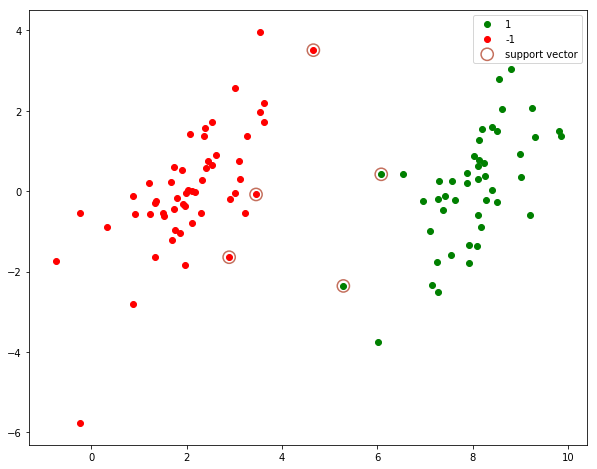

In [26]:
plot(dataArr, labelArr, alphas)

## 4. 利用完整Platt SMO算法加速优化

在大规模数据集上，简化版的SMO算法运行效率比较低，完整版的Platt SMO算法应用了一些能够提速的启发方法。

Platt SMO算法是通过一个外循环来选择第一个alpha值，并且选择过程会在两种方式之间进行交替：一种方式是在所有数据集熵进行单遍扫描，另一种方式则是在非边界alpha中实现单遍扫描。

In [5]:
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol= toler
        self.m = dataMatIn.shape[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m, 2)))

In [6]:
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas, oS.labelMat).T*(oS.X*oS.X[k, :].T)) + oS.b
    Ek = fXk- float(oS.labelMat[k])
    return Ek

In [7]:
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = np.nonzero(oS.eCache[:, 0].A)[0]
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

In [8]:
def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [9]:
# 优化例程
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print('L==H')
            return 0
        eta = 2.0 * oS.X[i, :]*oS.X[j, :].T - oS.X[i, :]*oS.X[i, :].T - oS.X[j, :]*oS.X[j, :].T
        if eta >= 0:
            print('eta>=0')
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print('j not moving enough')
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold-oS.alphas[j])
        updateEk(oS, i)
        b1 = (oS.b - Ei - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i, :]*oS.X[i, :].T
              -oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i, :]*oS.X[j, :].T)
        b2 = (oS.b - Ej - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i, :]*oS.X[j, :].T
              -oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j, :]*oS.X[j, :].T)
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1+b2)/2
        return 1
    else:
        return 0

In [21]:
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup=('lin', 0)):
    oS = optStruct(np.mat(dataMatIn), np.mat(classLabels).T, C, toler, kTup)
    iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
            print('fullset, iter: {0} i: {1}, pairs changed {2}'.format(iter, i, alphaPairsChanged))
            iter += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                print('non-bound, iter: {0} i: {1}, pairs changed {2}'.format(iter, i, alphaPairsChanged))
            iter += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
        print('iteration number: {0}'.format(iter))
    return oS.b, oS.alphas

In [156]:
dataArr, labelArr = loadDataSet('testSet.txt')
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)

L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
fullset, iter: 0 i: 99, pairs changed 6
iteration number: 1
j not moving enough
non-bound, iter: 1 i: 0, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 3, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 4, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 17, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 18, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 25, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 46, pairs changed 0
non-bound, iter: 1 i: 55, pairs changed 0
non-bound, iter: 1 i: 94, pairs changed 0
iteration number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not

In [10]:
# 计算超平面
def calcWs(alphas, dataArr, classLabels):
    X = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m, n = X.shape
    w = np.zeros((n, 1))
    for i in range(m):
        w += np.multiply(alphas[i]*labelMat[i], X[i, :].T)
    return w

In [158]:
ws = calcWs(alphas, dataArr, labelArr)
ws

array([[ 0.65307162],
       [-0.17196128]])

In [11]:
# 添加分割线
def plot(dataArr, labelArr, alphas, w, b):
    dataTemp = np.array(dataArr)
    labelTemp = np.array(labelArr)
    data1 = dataTemp[labelTemp == 1.0]
    data2 = dataTemp[labelTemp == -1.0]
    m = len(dataArr)
    supportVec = []
    for i in range(m):
        if alphas[i] > 0.0:
            supportVec.append(dataArr[i])
    supportVec = np.array(supportVec)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(data1[:, 0], data1[:, 1], c='g', label="1")
    ax.scatter(data2[:, 0], data2[:, 1], c='r', label="-1")
    ax.scatter(supportVec[:, 0], supportVec[:, 1], s=150, c='none', alpha=0.7,
                       linewidth=1.5, edgecolor='#AB3319', label="support vector")
    # 分割线
    x1, _ = min(dataArr, key=lambda x: x[0])
    x2, _ = max(dataArr, key=lambda x: x[0])
    a1, a2 = w
    a1 = float(a1)
    a2 = float(a2)
    b = float(b)
    y1, y2 = (-b-a1*x1)/a2, (-b-a1*x2)/a2
    ax.plot([x1, x2], [y1, y2])
    plt.legend(loc='best')
    plt.show()

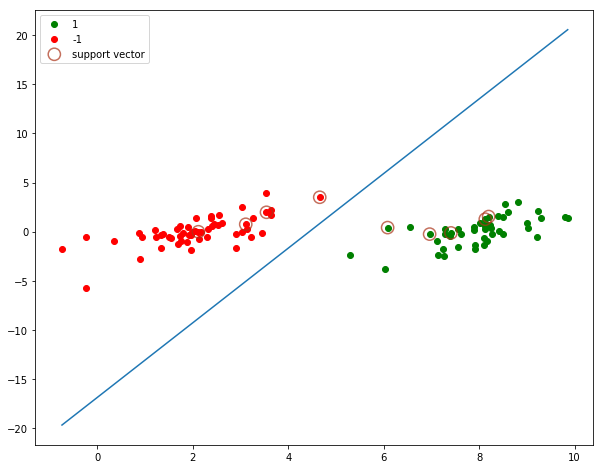

In [171]:
plot(dataArr, labelArr, alphas, ws, b)

## 5. 在复杂数据上应用核函数

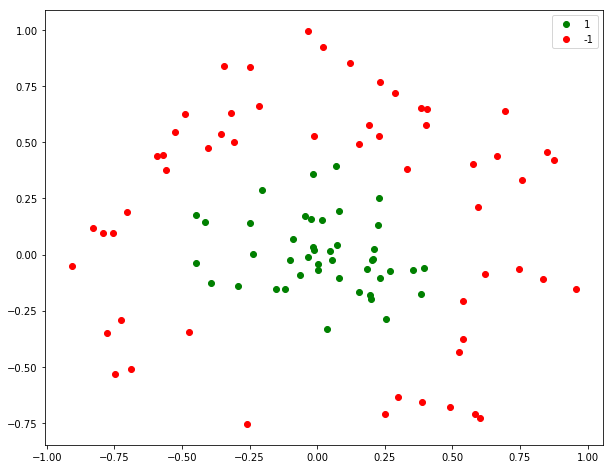

In [172]:
dataArr, labelArr = loadDataSet('testSetRBF.txt')
dataTemp = np.array(dataArr)
labelTemp = np.array(labelArr)
data1 = dataTemp[labelTemp == 1.0]
data2 = dataTemp[labelTemp == -1.0]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data1[:, 0], data1[:, 1], c='g', label="1")
ax.scatter(data2[:, 0], data2[:, 1], c='r', label="-1")
plt.legend(loc='best')
plt.show()

有的时候数据并不是线性可分的，但是利用核函数（kernel）这种强大的工具可以将数据转换成易于分类器理解的形式，其中径向基函数（radial basis function）是最流行的核函数。

### 5.1 利用核函数将数据映射到高维空间

在某个特征空间不易处理的问题，可以通过映射到另一个特征空间来解决，通常情况，这种映射会将地位特征空间映射到高维特征空间。

这种从某个特征空间到另一个特征空间的映射是通过核函数实现的，核函数可以理解为一个包装器或者接口，将数据从某个很难处理的形式转换成另一个较为容易处理的形式。

SVM优化中一个特别好的地方就是所有的运算都可以写成内积得形式。

### 5.2 径向基函数

径向基函数是SVM中常用的一个核函数。

$k\left( x,y\right) =\exp \left( \dfrac {-\left\| x-y\right\| ^{2}}{2\sigma ^{2}}\right)$

In [25]:
def kernelTrans(X, A, kTup):
    m, n = X.shape
    K = np.mat(np.zeros((m, 1)))
    if kTup[0] == 'lin':
        K = X * A.T
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-kTup[1]**2))
    else:
        raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K

In [23]:
# 重构optStruct
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = dataMatIn.shape[0]
        self.alphas = np.mat(np.zeros((self.m, 1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m, 2)))
        self.K = np.mat(np.zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i, :], kTup)

In [27]:
# 重构innerL
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print('L==H')
            return 0
        eta = 2.0 * oS.K[i, j] - oS.K[i, i] - oS.K[j, j]
        if eta >= 0:
            print('eta>=0')
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEk(oS, j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            print('j not moving enough')
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold-oS.alphas[j])
        updateEk(oS, i)
        b1 = (oS.b - Ei - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i, i]
              -oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i, j])
        b2 = (oS.b - Ej - oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i, j]
              -oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j, j])
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1+b2)/2
        return 1
    else:
        return 0

In [17]:
# 重构calcEk
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas, oS.labelMat).T*(oS.K[:, k]) + oS.b)
    Ek = fXk- float(oS.labelMat[k])
    return Ek

### 5.3 在测试中使用核函数

In [29]:
def testRbf(k1=1.3):
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).T
    svInd = np.nonzero(alphas.A > 0)[0]
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    print('there are {0} Support Vectors'.format(sVs.shape[0]))
    m, n = dataMat.shape
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], ('rbf', k1))
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print('the training error rate is: {0}'.format(errorCount/m))
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).T
    m, n = dataMat.shape
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], ('rbf', k1))
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print('the test error rate is: {0}'.format(errorCount/m))
    return alphas, b

In [31]:
alphas, b = testRbf()

L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
fullset, iter: 0 i: 99, pairs changed 28
iteration number: 1
j not moving enough
non-bound, iter: 1 i: 0, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 1, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 3, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 10, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 11, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 13, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 14, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 15, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 16, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 17, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 18, pairs changed 0
j not moving enough
non-bound, iter: 1 i: 19, pairs changed 0
non-bound, iter: 1 i: 21, pairs change

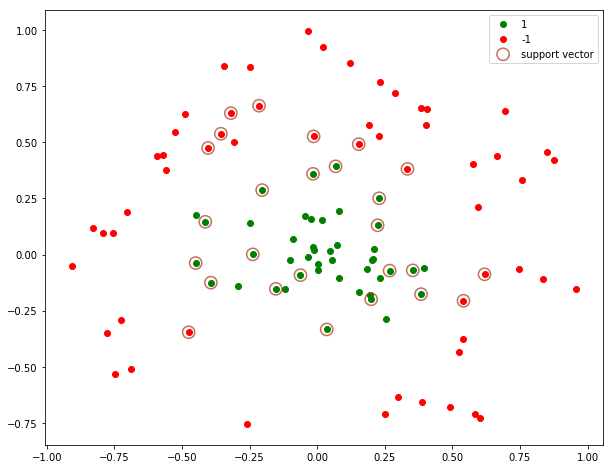

In [33]:
dataArr, labelArr = loadDataSet('testSetRBF.txt')
plot(dataArr, labelArr, alphas)

支持向量的数目存在一个最优值，SVM的有带你在于它能对数据进行高效分类。

如果支持向量太少，就可能会得到一个很差的决策边界；如果支持向量太多，也就相当于每次都会利用整个数据集进行分类，这种分类方法称为k近邻。

上述程序中，k1的值越小，就是减少每个支持向量的影响程度，因此需要更多的支持向量。

## 6. 示例：手写识别问题回顾

在kNN中我们已经用过这个数据集，kNN的计算量很大，这里我们换种方法，在保持性能不变的同时使用更少的内存。

In [34]:
from os import listdir

In [35]:
def img2vector(filename):
    returnVect = np.zeros((1, 1024))
    with open(filename) as f:
        for i in range(32):
            lineStr = f.readline()
            for j in range(32):
                returnVect[0, i*32+j] = int(lineStr[j])
    return returnVect

In [37]:
def loadImage(dirName):
    hwLabels = []
    trainingFileList = listdir(dirName)
    m = len(trainingFileList)
    traingingMat = np.zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9:
            hwLabels.append(-1)
        else:
            hwLabels.append(1)
        traingingMat[i, :] = img2vector('{0}/{1}'.format(dirName, fileNameStr))
    return traingingMat, hwLabels

In [42]:
def testDigits(kTup=('rbf', 10)):
    dataArr, labelArr = loadImage('digits/trainingDigits')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).T
    svInd = np.nonzero(alphas.A > 0)[0]
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    #print('there are {0} Support Vectors'.format(sVs.shape[0]))
    m, n = dataMat.shape
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], kTup)
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    trainingError = errorCount/m
    #print('the training error rate is: {0}'.format(trainingError))
    dataArr, labelArr = loadImage('digits/testDigits')
    dataMat = np.mat(dataArr)
    labelMat = np.mat(labelArr).T
    m, n = dataMat.shape
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataMat[i, :], kTup)
        predict = kernelEval.T * np.multiply(labelSV, alphas[svInd]) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    testError = errorCount/m
    #print('the test error rate is: {0}'.format(testError))
    return trainingError, testError, sVs.shape[0]

In [39]:
trainingError, testError, vectNum = testDigits()

L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H


j not moving enough
non-bound, iter: 2 i: 205, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 207, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 208, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 210, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 215, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 218, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 226, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 230, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 232, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 234, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 235, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 236, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 238, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 242, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 243, pairs changed 15
j not moving enough
non-bound, iter: 2 i

j not moving enough
non-bound, iter: 3 i: 208, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 210, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 215, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 218, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 226, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 230, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 232, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 234, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 235, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 236, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 238, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 242, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 243, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 245, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 246, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 249, pairs ch

j not moving enough
non-bound, iter: 5 i: 10, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 13, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 14, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 15, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 16, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 19, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 20, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 21, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 22, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 23, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 47, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 49, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 52, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 59, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 60, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 63, pairs changed 0
j not mo

L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
j not

In [41]:
trainingError, testError, vectNum

(0.0, 0.005376344086021506, 133)

In [44]:
# 更改参数
result = []
for i in [0.2, 5, 10, 50, 100]:
    trainingError, testError, vectNum = testDigits(('rbf', i))
    result.append([trainingError, testError, vectNum])
trainingError, testError, vectNum = testDigits(('lin', 0))
result.append([trainingError, testError, vectNum])

L==H
fullset, iter: 0 i: 401, pairs changed 401
iteration number: 1
non-bound, iter: 1 i: 0, pairs changed 1
non-bound, iter: 1 i: 1, pairs changed 2
non-bound, iter: 1 i: 2, pairs changed 3
non-bound, iter: 1 i: 3, pairs changed 4
non-bound, iter: 1 i: 4, pairs changed 5
non-bound, iter: 1 i: 5, pairs changed 6
non-bound, iter: 1 i: 6, pairs changed 7
non-bound, iter: 1 i: 7, pairs changed 8
non-bound, iter: 1 i: 8, pairs changed 9
non-bound, iter: 1 i: 9, pairs changed 10
non-bound, iter: 1 i: 10, pairs changed 11
non-bound, iter: 1 i: 11, pairs changed 12
non-bound, iter: 1 i: 12, pairs changed 13
non-bound, iter: 1 i: 13, pairs changed 14
non-bound, iter: 1 i: 14, pairs changed 15
non-bound, iter: 1 i: 15, pairs changed 16
non-bound, iter: 1 i: 16, pairs changed 17
non-bound, iter: 1 i: 17, pairs changed 18
non-bound, iter: 1 i: 18, pairs changed 19
non-bound, iter: 1 i: 19, pairs changed 20
non-bound, iter: 1 i: 20, pairs changed 21
non-bound, iter: 1 i: 21, pairs changed 22
non-b

non-bound, iter: 1 i: 193, pairs changed 194
non-bound, iter: 1 i: 194, pairs changed 195
non-bound, iter: 1 i: 195, pairs changed 196
non-bound, iter: 1 i: 196, pairs changed 197
non-bound, iter: 1 i: 197, pairs changed 198
non-bound, iter: 1 i: 198, pairs changed 199
non-bound, iter: 1 i: 199, pairs changed 199
non-bound, iter: 1 i: 200, pairs changed 200
non-bound, iter: 1 i: 201, pairs changed 201
non-bound, iter: 1 i: 202, pairs changed 202
non-bound, iter: 1 i: 203, pairs changed 203
non-bound, iter: 1 i: 204, pairs changed 204
non-bound, iter: 1 i: 205, pairs changed 205
non-bound, iter: 1 i: 206, pairs changed 206
non-bound, iter: 1 i: 207, pairs changed 207
non-bound, iter: 1 i: 208, pairs changed 208
non-bound, iter: 1 i: 209, pairs changed 209
non-bound, iter: 1 i: 210, pairs changed 210
non-bound, iter: 1 i: 211, pairs changed 211
non-bound, iter: 1 i: 212, pairs changed 212
non-bound, iter: 1 i: 213, pairs changed 213
non-bound, iter: 1 i: 214, pairs changed 214
non-bound,

non-bound, iter: 1 i: 378, pairs changed 378
non-bound, iter: 1 i: 379, pairs changed 379
non-bound, iter: 1 i: 380, pairs changed 380
non-bound, iter: 1 i: 381, pairs changed 381
non-bound, iter: 1 i: 382, pairs changed 382
non-bound, iter: 1 i: 383, pairs changed 383
non-bound, iter: 1 i: 384, pairs changed 384
non-bound, iter: 1 i: 385, pairs changed 385
non-bound, iter: 1 i: 386, pairs changed 386
non-bound, iter: 1 i: 387, pairs changed 387
non-bound, iter: 1 i: 388, pairs changed 388
non-bound, iter: 1 i: 389, pairs changed 389
non-bound, iter: 1 i: 390, pairs changed 390
non-bound, iter: 1 i: 391, pairs changed 391
non-bound, iter: 1 i: 392, pairs changed 392
non-bound, iter: 1 i: 393, pairs changed 393
non-bound, iter: 1 i: 394, pairs changed 394
non-bound, iter: 1 i: 395, pairs changed 395
non-bound, iter: 1 i: 396, pairs changed 396
non-bound, iter: 1 i: 397, pairs changed 397
non-bound, iter: 1 i: 398, pairs changed 398
non-bound, iter: 1 i: 399, pairs changed 399
non-bound,

non-bound, iter: 2 i: 168, pairs changed 156
non-bound, iter: 2 i: 169, pairs changed 157
non-bound, iter: 2 i: 170, pairs changed 158
non-bound, iter: 2 i: 171, pairs changed 159
non-bound, iter: 2 i: 172, pairs changed 160
non-bound, iter: 2 i: 173, pairs changed 161
non-bound, iter: 2 i: 174, pairs changed 162
non-bound, iter: 2 i: 175, pairs changed 163
non-bound, iter: 2 i: 176, pairs changed 164
non-bound, iter: 2 i: 177, pairs changed 165
non-bound, iter: 2 i: 178, pairs changed 166
non-bound, iter: 2 i: 179, pairs changed 167
non-bound, iter: 2 i: 180, pairs changed 168
non-bound, iter: 2 i: 181, pairs changed 169
non-bound, iter: 2 i: 182, pairs changed 170
non-bound, iter: 2 i: 183, pairs changed 171
non-bound, iter: 2 i: 184, pairs changed 172
non-bound, iter: 2 i: 185, pairs changed 173
non-bound, iter: 2 i: 186, pairs changed 174
non-bound, iter: 2 i: 187, pairs changed 175
non-bound, iter: 2 i: 188, pairs changed 176
non-bound, iter: 2 i: 189, pairs changed 177
non-bound,

non-bound, iter: 2 i: 364, pairs changed 342
non-bound, iter: 2 i: 365, pairs changed 343
non-bound, iter: 2 i: 366, pairs changed 344
non-bound, iter: 2 i: 367, pairs changed 345
non-bound, iter: 2 i: 368, pairs changed 346
non-bound, iter: 2 i: 369, pairs changed 347
non-bound, iter: 2 i: 370, pairs changed 348
non-bound, iter: 2 i: 371, pairs changed 349
non-bound, iter: 2 i: 372, pairs changed 350
non-bound, iter: 2 i: 373, pairs changed 351
non-bound, iter: 2 i: 374, pairs changed 352
non-bound, iter: 2 i: 375, pairs changed 353
non-bound, iter: 2 i: 376, pairs changed 354
non-bound, iter: 2 i: 377, pairs changed 355
non-bound, iter: 2 i: 378, pairs changed 356
non-bound, iter: 2 i: 379, pairs changed 357
non-bound, iter: 2 i: 380, pairs changed 358
non-bound, iter: 2 i: 381, pairs changed 359
non-bound, iter: 2 i: 382, pairs changed 360
non-bound, iter: 2 i: 383, pairs changed 361
non-bound, iter: 2 i: 384, pairs changed 362
non-bound, iter: 2 i: 385, pairs changed 363
non-bound,

non-bound, iter: 3 i: 181, pairs changed 118
non-bound, iter: 3 i: 182, pairs changed 119
non-bound, iter: 3 i: 183, pairs changed 120
non-bound, iter: 3 i: 184, pairs changed 121
non-bound, iter: 3 i: 185, pairs changed 122
non-bound, iter: 3 i: 186, pairs changed 122
non-bound, iter: 3 i: 187, pairs changed 122
non-bound, iter: 3 i: 188, pairs changed 122
non-bound, iter: 3 i: 189, pairs changed 123
non-bound, iter: 3 i: 190, pairs changed 124
non-bound, iter: 3 i: 191, pairs changed 125
non-bound, iter: 3 i: 192, pairs changed 125
non-bound, iter: 3 i: 193, pairs changed 125
non-bound, iter: 3 i: 194, pairs changed 125
non-bound, iter: 3 i: 195, pairs changed 126
non-bound, iter: 3 i: 196, pairs changed 126
non-bound, iter: 3 i: 197, pairs changed 127
non-bound, iter: 3 i: 198, pairs changed 128
non-bound, iter: 3 i: 199, pairs changed 128
non-bound, iter: 3 i: 200, pairs changed 129
non-bound, iter: 3 i: 201, pairs changed 129
non-bound, iter: 3 i: 202, pairs changed 129
non-bound,

non-bound, iter: 4 i: 240, pairs changed 5
non-bound, iter: 4 i: 241, pairs changed 5
non-bound, iter: 4 i: 242, pairs changed 5
non-bound, iter: 4 i: 243, pairs changed 5
non-bound, iter: 4 i: 244, pairs changed 5
non-bound, iter: 4 i: 245, pairs changed 5
non-bound, iter: 4 i: 246, pairs changed 5
non-bound, iter: 4 i: 247, pairs changed 5
non-bound, iter: 4 i: 248, pairs changed 5
non-bound, iter: 4 i: 249, pairs changed 5
non-bound, iter: 4 i: 250, pairs changed 5
non-bound, iter: 4 i: 251, pairs changed 5
non-bound, iter: 4 i: 252, pairs changed 5
non-bound, iter: 4 i: 253, pairs changed 5
non-bound, iter: 4 i: 254, pairs changed 5
non-bound, iter: 4 i: 255, pairs changed 5
non-bound, iter: 4 i: 256, pairs changed 5
non-bound, iter: 4 i: 257, pairs changed 5
non-bound, iter: 4 i: 258, pairs changed 5
non-bound, iter: 4 i: 259, pairs changed 5
non-bound, iter: 4 i: 260, pairs changed 5
non-bound, iter: 4 i: 261, pairs changed 5
non-bound, iter: 4 i: 262, pairs changed 5
non-bound, 

non-bound, iter: 5 i: 397, pairs changed 0
non-bound, iter: 5 i: 398, pairs changed 0
non-bound, iter: 5 i: 399, pairs changed 0
non-bound, iter: 5 i: 400, pairs changed 0
non-bound, iter: 5 i: 401, pairs changed 0
iteration number: 6
fullset, iter: 6 i: 401, pairs changed 0
iteration number: 7
L==H
fullset, iter: 0 i: 401, pairs changed 401
iteration number: 1
non-bound, iter: 1 i: 0, pairs changed 1
non-bound, iter: 1 i: 1, pairs changed 2
non-bound, iter: 1 i: 2, pairs changed 3
non-bound, iter: 1 i: 3, pairs changed 4
non-bound, iter: 1 i: 4, pairs changed 5
non-bound, iter: 1 i: 5, pairs changed 6
non-bound, iter: 1 i: 6, pairs changed 7
non-bound, iter: 1 i: 7, pairs changed 8
non-bound, iter: 1 i: 8, pairs changed 9
non-bound, iter: 1 i: 9, pairs changed 10
non-bound, iter: 1 i: 10, pairs changed 11
non-bound, iter: 1 i: 11, pairs changed 12
non-bound, iter: 1 i: 12, pairs changed 13
non-bound, iter: 1 i: 13, pairs changed 14
non-bound, iter: 1 i: 14, pairs changed 15
non-bound,

non-bound, iter: 1 i: 189, pairs changed 189
non-bound, iter: 1 i: 190, pairs changed 190
non-bound, iter: 1 i: 191, pairs changed 191
non-bound, iter: 1 i: 192, pairs changed 192
non-bound, iter: 1 i: 193, pairs changed 193
non-bound, iter: 1 i: 194, pairs changed 194
non-bound, iter: 1 i: 195, pairs changed 195
non-bound, iter: 1 i: 196, pairs changed 196
non-bound, iter: 1 i: 197, pairs changed 197
non-bound, iter: 1 i: 198, pairs changed 198
non-bound, iter: 1 i: 199, pairs changed 199
non-bound, iter: 1 i: 200, pairs changed 200
non-bound, iter: 1 i: 201, pairs changed 201
non-bound, iter: 1 i: 202, pairs changed 202
non-bound, iter: 1 i: 203, pairs changed 203
non-bound, iter: 1 i: 204, pairs changed 204
non-bound, iter: 1 i: 205, pairs changed 205
non-bound, iter: 1 i: 206, pairs changed 206
non-bound, iter: 1 i: 207, pairs changed 207
non-bound, iter: 1 i: 208, pairs changed 208
non-bound, iter: 1 i: 209, pairs changed 209
non-bound, iter: 1 i: 210, pairs changed 210
non-bound,

non-bound, iter: 1 i: 380, pairs changed 380
non-bound, iter: 1 i: 381, pairs changed 381
non-bound, iter: 1 i: 382, pairs changed 382
non-bound, iter: 1 i: 383, pairs changed 383
non-bound, iter: 1 i: 384, pairs changed 384
non-bound, iter: 1 i: 385, pairs changed 385
non-bound, iter: 1 i: 386, pairs changed 386
non-bound, iter: 1 i: 387, pairs changed 387
non-bound, iter: 1 i: 388, pairs changed 388
non-bound, iter: 1 i: 389, pairs changed 389
non-bound, iter: 1 i: 390, pairs changed 390
non-bound, iter: 1 i: 391, pairs changed 391
non-bound, iter: 1 i: 392, pairs changed 392
non-bound, iter: 1 i: 393, pairs changed 393
non-bound, iter: 1 i: 394, pairs changed 394
non-bound, iter: 1 i: 395, pairs changed 395
non-bound, iter: 1 i: 396, pairs changed 396
non-bound, iter: 1 i: 397, pairs changed 397
non-bound, iter: 1 i: 398, pairs changed 398
non-bound, iter: 1 i: 399, pairs changed 399
non-bound, iter: 1 i: 400, pairs changed 400
non-bound, iter: 1 i: 401, pairs changed 401
iteration 

non-bound, iter: 2 i: 174, pairs changed 173
non-bound, iter: 2 i: 175, pairs changed 174
non-bound, iter: 2 i: 176, pairs changed 175
non-bound, iter: 2 i: 177, pairs changed 176
non-bound, iter: 2 i: 178, pairs changed 177
non-bound, iter: 2 i: 179, pairs changed 178
non-bound, iter: 2 i: 180, pairs changed 179
non-bound, iter: 2 i: 181, pairs changed 180
non-bound, iter: 2 i: 182, pairs changed 181
non-bound, iter: 2 i: 183, pairs changed 182
non-bound, iter: 2 i: 184, pairs changed 183
non-bound, iter: 2 i: 185, pairs changed 184
non-bound, iter: 2 i: 186, pairs changed 184
non-bound, iter: 2 i: 187, pairs changed 185
non-bound, iter: 2 i: 188, pairs changed 186
non-bound, iter: 2 i: 189, pairs changed 187
non-bound, iter: 2 i: 190, pairs changed 188
non-bound, iter: 2 i: 191, pairs changed 189
non-bound, iter: 2 i: 192, pairs changed 190
non-bound, iter: 2 i: 193, pairs changed 191
non-bound, iter: 2 i: 194, pairs changed 192
non-bound, iter: 2 i: 195, pairs changed 193
non-bound,

non-bound, iter: 2 i: 362, pairs changed 353
non-bound, iter: 2 i: 363, pairs changed 354
non-bound, iter: 2 i: 364, pairs changed 355
non-bound, iter: 2 i: 365, pairs changed 356
non-bound, iter: 2 i: 366, pairs changed 357
non-bound, iter: 2 i: 367, pairs changed 358
non-bound, iter: 2 i: 368, pairs changed 359
non-bound, iter: 2 i: 369, pairs changed 360
non-bound, iter: 2 i: 370, pairs changed 361
non-bound, iter: 2 i: 371, pairs changed 362
non-bound, iter: 2 i: 372, pairs changed 363
non-bound, iter: 2 i: 373, pairs changed 364
non-bound, iter: 2 i: 374, pairs changed 365
non-bound, iter: 2 i: 375, pairs changed 365
non-bound, iter: 2 i: 376, pairs changed 366
non-bound, iter: 2 i: 377, pairs changed 367
non-bound, iter: 2 i: 378, pairs changed 368
non-bound, iter: 2 i: 379, pairs changed 369
non-bound, iter: 2 i: 380, pairs changed 370
non-bound, iter: 2 i: 381, pairs changed 371
non-bound, iter: 2 i: 382, pairs changed 372
non-bound, iter: 2 i: 383, pairs changed 373
non-bound,

non-bound, iter: 3 i: 158, pairs changed 151
non-bound, iter: 3 i: 159, pairs changed 152
non-bound, iter: 3 i: 160, pairs changed 153
non-bound, iter: 3 i: 161, pairs changed 154
non-bound, iter: 3 i: 162, pairs changed 155
non-bound, iter: 3 i: 163, pairs changed 156
non-bound, iter: 3 i: 164, pairs changed 157
non-bound, iter: 3 i: 165, pairs changed 158
non-bound, iter: 3 i: 166, pairs changed 159
non-bound, iter: 3 i: 167, pairs changed 160
non-bound, iter: 3 i: 168, pairs changed 160
non-bound, iter: 3 i: 169, pairs changed 161
non-bound, iter: 3 i: 170, pairs changed 162
non-bound, iter: 3 i: 171, pairs changed 163
non-bound, iter: 3 i: 172, pairs changed 164
non-bound, iter: 3 i: 173, pairs changed 165
non-bound, iter: 3 i: 174, pairs changed 166
non-bound, iter: 3 i: 175, pairs changed 167
non-bound, iter: 3 i: 176, pairs changed 168
non-bound, iter: 3 i: 177, pairs changed 169
non-bound, iter: 3 i: 178, pairs changed 170
non-bound, iter: 3 i: 179, pairs changed 171
non-bound,

non-bound, iter: 3 i: 343, pairs changed 321
non-bound, iter: 3 i: 344, pairs changed 322
non-bound, iter: 3 i: 345, pairs changed 323
non-bound, iter: 3 i: 346, pairs changed 324
non-bound, iter: 3 i: 347, pairs changed 325
non-bound, iter: 3 i: 348, pairs changed 326
non-bound, iter: 3 i: 349, pairs changed 327
non-bound, iter: 3 i: 350, pairs changed 328
non-bound, iter: 3 i: 351, pairs changed 329
non-bound, iter: 3 i: 352, pairs changed 330
non-bound, iter: 3 i: 353, pairs changed 331
non-bound, iter: 3 i: 354, pairs changed 332
non-bound, iter: 3 i: 355, pairs changed 332
non-bound, iter: 3 i: 356, pairs changed 333
non-bound, iter: 3 i: 357, pairs changed 334
non-bound, iter: 3 i: 358, pairs changed 335
non-bound, iter: 3 i: 359, pairs changed 336
non-bound, iter: 3 i: 360, pairs changed 336
non-bound, iter: 3 i: 361, pairs changed 337
non-bound, iter: 3 i: 362, pairs changed 337
non-bound, iter: 3 i: 363, pairs changed 337
non-bound, iter: 3 i: 364, pairs changed 338
non-bound,

non-bound, iter: 4 i: 138, pairs changed 105
non-bound, iter: 4 i: 139, pairs changed 105
non-bound, iter: 4 i: 140, pairs changed 106
non-bound, iter: 4 i: 141, pairs changed 106
non-bound, iter: 4 i: 142, pairs changed 106
non-bound, iter: 4 i: 143, pairs changed 106
non-bound, iter: 4 i: 144, pairs changed 106
non-bound, iter: 4 i: 145, pairs changed 107
non-bound, iter: 4 i: 146, pairs changed 107
non-bound, iter: 4 i: 147, pairs changed 108
non-bound, iter: 4 i: 148, pairs changed 108
non-bound, iter: 4 i: 149, pairs changed 108
non-bound, iter: 4 i: 150, pairs changed 109
non-bound, iter: 4 i: 151, pairs changed 110
non-bound, iter: 4 i: 152, pairs changed 110
non-bound, iter: 4 i: 153, pairs changed 110
non-bound, iter: 4 i: 154, pairs changed 111
non-bound, iter: 4 i: 155, pairs changed 112
non-bound, iter: 4 i: 156, pairs changed 113
non-bound, iter: 4 i: 157, pairs changed 113
non-bound, iter: 4 i: 158, pairs changed 114
non-bound, iter: 4 i: 159, pairs changed 115
non-bound,

non-bound, iter: 4 i: 336, pairs changed 191
non-bound, iter: 4 i: 337, pairs changed 192
non-bound, iter: 4 i: 338, pairs changed 192
non-bound, iter: 4 i: 339, pairs changed 193
non-bound, iter: 4 i: 340, pairs changed 193
non-bound, iter: 4 i: 341, pairs changed 193
non-bound, iter: 4 i: 342, pairs changed 193
non-bound, iter: 4 i: 343, pairs changed 194
non-bound, iter: 4 i: 344, pairs changed 195
non-bound, iter: 4 i: 345, pairs changed 195
non-bound, iter: 4 i: 346, pairs changed 196
non-bound, iter: 4 i: 347, pairs changed 196
non-bound, iter: 4 i: 348, pairs changed 197
non-bound, iter: 4 i: 349, pairs changed 198
non-bound, iter: 4 i: 350, pairs changed 198
non-bound, iter: 4 i: 351, pairs changed 198
non-bound, iter: 4 i: 352, pairs changed 198
non-bound, iter: 4 i: 353, pairs changed 199
non-bound, iter: 4 i: 354, pairs changed 200
non-bound, iter: 4 i: 355, pairs changed 201
non-bound, iter: 4 i: 356, pairs changed 201
non-bound, iter: 4 i: 357, pairs changed 202
non-bound,

non-bound, iter: 5 i: 237, pairs changed 24
non-bound, iter: 5 i: 238, pairs changed 24
non-bound, iter: 5 i: 239, pairs changed 24
non-bound, iter: 5 i: 240, pairs changed 24
non-bound, iter: 5 i: 241, pairs changed 24
non-bound, iter: 5 i: 242, pairs changed 24
non-bound, iter: 5 i: 243, pairs changed 24
non-bound, iter: 5 i: 244, pairs changed 24
non-bound, iter: 5 i: 245, pairs changed 24
non-bound, iter: 5 i: 246, pairs changed 24
non-bound, iter: 5 i: 247, pairs changed 24
non-bound, iter: 5 i: 248, pairs changed 24
non-bound, iter: 5 i: 249, pairs changed 24
non-bound, iter: 5 i: 250, pairs changed 24
non-bound, iter: 5 i: 251, pairs changed 24
non-bound, iter: 5 i: 252, pairs changed 24
non-bound, iter: 5 i: 253, pairs changed 24
non-bound, iter: 5 i: 254, pairs changed 24
non-bound, iter: 5 i: 255, pairs changed 24
non-bound, iter: 5 i: 256, pairs changed 24
non-bound, iter: 5 i: 257, pairs changed 24
non-bound, iter: 5 i: 258, pairs changed 24
non-bound, iter: 5 i: 259, pairs

L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H


j not moving enough
non-bound, iter: 2 i: 226, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 230, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 232, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 234, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 235, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 236, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 238, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 242, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 243, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 245, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 246, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 249, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 252, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 253, pairs changed 15
j not moving enough
non-bound, iter: 2 i: 254, pairs changed 15
j not moving enough
non-bound, iter: 2 i

j not moving enough
non-bound, iter: 3 i: 242, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 243, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 245, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 246, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 249, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 252, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 253, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 254, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 259, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 271, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 275, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 277, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 284, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 287, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 290, pairs changed 0
j not moving enough
non-bound, iter: 3 i: 293, pairs ch

j not moving enough
non-bound, iter: 5 i: 77, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 81, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 82, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 85, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 87, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 98, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 101, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 103, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 105, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 115, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 116, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 117, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 119, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 120, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 124, pairs changed 0
j not moving enough
non-bound, iter: 5 i: 125, pairs changed 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
j not

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
L==H
L==H
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not movi

j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
j not moving enough
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
fullset, iter: 0 i: 401, pairs changed 18
iteration number: 1
non-bound, iter: 1 i: 1, pairs changed 1
non-bound, iter: 1 i: 2, pairs changed 2
j not moving enough
non-bound, iter: 1 i: 3, pairs changed 2
non-bound, iter: 1 i: 7, pairs changed 3
non-bound, iter: 1 i: 14, pairs changed 4
non-bound, iter: 1 i: 63, pairs changed 5
j not moving enough
non-bound, iter: 1 i: 85, pairs changed 5
non-bound, iter: 1 i: 117, pairs changed 6
non-bound, iter: 1 i: 127, pairs changed 6
j not moving enou

In [45]:
for item in result:
    print(item)

[0.0, 0.521505376344086, 402]
[0.0, 0.03225806451612903, 402]
[0.0, 0.005376344086021506, 133]
[0.012437810945273632, 0.016129032258064516, 36]
[0.009950248756218905, 0.010752688172043012, 32]
[0.02736318407960199, 0.03763440860215054, 33]


> 总结：支持向量机是一种分类器，会产生一个二至决策结果，繁华错误率低，也就是说具有良好的学习能力，且学到的结果具有很好的推广性，有些人认为它是监督学习中最好的定式算法。

> 支持向量机试图通过求解一个二次优化问题来最大化分类间隔，SMO算法大大加快了SVM的训练速度。

> 核方法将一个在低维空间中的非线性问题转换成高维空间下的线性问题来求解。